# Building a collaborative Multi-Agent System in LangGraph

This project will develop how to build a collaborative Multi-Agent System in LangGraph to build our own Data Analyst!

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4o`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".
This is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation, by Wu, et. al.](https://arxiv.org/pdf/2308.08155)

The typical workflow here would be to have the following:

- A Researcher Agent which can leverage tools like search to get live information from user queries
- A Chart Generator Agent which is an expert in taking data and building visualizations in Python
- A router which will help in calling the right agent and tools based on the current state in the agent.



## Install OpenAI, and LangChain dependencies

Install the following httpx library version for compatibility with other libraries

In [1]:
!pip install httpx==0.27.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.16.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [2]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1
!pip install langchain-experimental==0.0.62

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.42
    Uninstalling langsmith-0.3.42:
      Successfully uninstalled langsmith-0.3.42
  Attempting uninstall: langchain-core
    Fo

## Setup Environment Variables

In [3]:
from google.colab import userdata
import os

os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Build Collaborative Multi-Agent System

Here we will build the key components of our collaborative multi-agent system

## Create Tools

Here we will be using the [Tavily API](https://tavily.com/#api) for our web searches

In [4]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


tv_search = TavilySearchResults(max_results=5, search_depth='advanced',
                                max_tokens=10000)

repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."],):
    """Use this to execute python code.
       If you want to see the output of a value,
       you should print it out with `print(...)`.

       This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")

### Graph State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Create Agents

We will create two main agents here:

1. The Researcher Agent which can access the web search tool to make web searches to get information on user queries
2. The Chart Agent which can use python to create data visualizations

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

llm = ChatOpenAI(model="gpt-4o", temperature=0)

search_tool = [tv_search]
search_tool_name = tv_search.name
research_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", f"""You are a helpful AI assistant, collaborating with other assistants.
                          Use the provided tools to progress towards answering the question.
                          If you are unable to fully answer, that's OK,
                          another assistant with different tools will help where you left off.
                          Execute what you can to make progress.
                          If you or any of the other assistants have the final answer or deliverable,
                          prefix your response with FINAL ANSWER so the team knows to stop.

                          You have access to the following tools:
                          {search_tool_name}

                          You should provide accurate data for use
                          and source code shouldn't be the final answer
                       """,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

research_agent = (research_prompt
                      |
                  llm.bind_tools(search_tool))


chart_tool = [python_repl]
chart_tool_name = python_repl.name
chart_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", f"""You are a helpful AI assistant, collaborating with other assistants.
                          Use the provided tools to progress towards answering the question.
                          If you are unable to fully answer, that's OK,
                          another assistant with different tools will help where you left off.
                          Execute what you can to make progress.
                          If you or any of the other assistants have the final answer or deliverable,
                          prefix your response with FINAL ANSWER so the team knows to stop.

                          You have access to the following tools:
                          {chart_tool_name}

                          Run the python code to display the chart
                       """,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

chart_agent = (chart_prompt
                  |
               llm.bind_tools(chart_tool))

### Define Agent Nodes

These functions would actually call the agents as necessary and update the state in the agent

In [7]:
from langchain_core.messages import ToolMessage, AIMessage

def research_agent_node(state):
    result = research_agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="Researcher")
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": "Researcher",
    }


def chart_agent_node(state):
    result = chart_agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="chart_generator")
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": "chart_generator",
    }


### Define Tool Node

Defines the tools we would be using in the multi-agent system

In [8]:
from langgraph.prebuilt import ToolNode

tools = [tv_search, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

Defines some of the conditional edge logic that is needed to decide what to do based on results of the agents




In [9]:
# Either agent can decide to end
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Multi-Agent Graph

We can now put it all together and define the graph!



In [10]:
from langgraph.graph import END, StateGraph

agent = StateGraph(AgentState)

agent.add_node("Researcher", research_agent_node)
agent.add_node("chart_generator", chart_agent_node)
agent.add_node("call_tool", tool_node)

agent.add_conditional_edges(
    "Researcher",
    router,
    # routing map
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
agent.add_conditional_edges(
    "chart_generator",
    router,
    # routing map
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

agent.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    # routing map
    {"Researcher": "Researcher", "chart_generator": "chart_generator"},
)

agent.set_entry_point("Researcher")
agent = agent.compile()

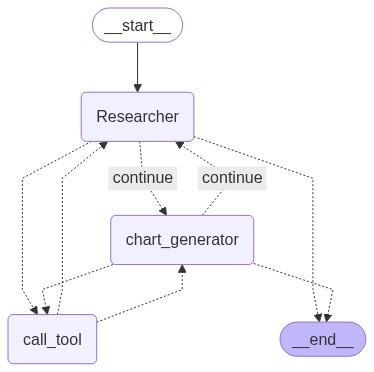

In [11]:
from IPython.display import Image, display, Markdown

display(Image(agent.get_graph().draw_mermaid_png()))

## Test the Multi-Agent System

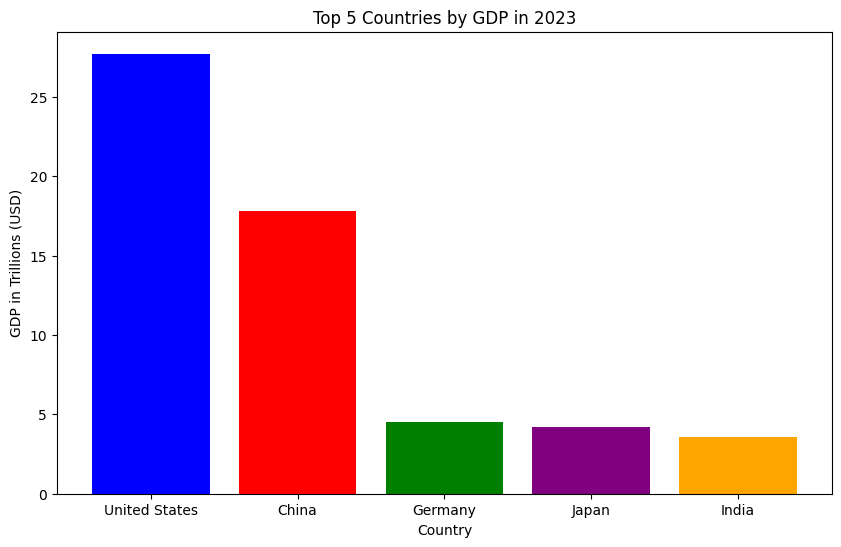

In [13]:
prompt = """Fetch the data of the top 5 countries with the highest GDP in the world.
            Then use this data and draw a bar chart.
         """

response = agent.invoke({"messages": [('human', prompt)]},
                        # Maximum number of steps to take in the graph
                        {"recursion_limit": 150},)

In [14]:
response

{'messages': [('human',
   'Fetch the data of the top 5 countries with the highest GDP in the world.\n            Then use this data and draw a bar chart.\n         '),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aryjvC52jiolbVI7qAeDwudV', 'function': {'arguments': '{"query":"top 5 countries by GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 235, 'total_tokens': 261, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-94cef463-98ae-4e7a-89a0-e56e8c9c7ac0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'top 5 countries by GDP 2023'}, 'id': 'call

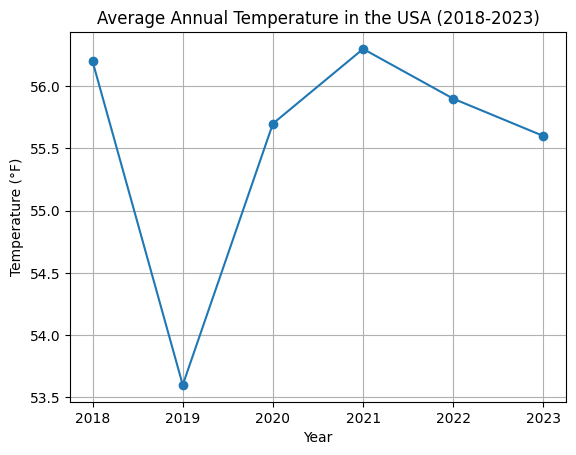

In [15]:
prompt = """Fetch the data of the average temperature of USA over the last 5 years.
            Then use this data and draw a line chart.
         """

response = agent.invoke({"messages": [('human', prompt)]},
                        # Maximum number of steps to take in the graph
                        {"recursion_limit": 150},)

In [16]:
response

{'messages': [('human',
   'Fetch the data of the average temperature of USA over the last 5 years.\n            Then use this data and draw a line chart.\n         '),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_alYf0AJX5Oxhd78GSsvRfJl6', 'function': {'arguments': '{"query":"average temperature USA last 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 234, 'total_tokens': 258, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-db32d9d4-7a84-46cb-ae45-543c36d7bd1f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'average temperature USA last 5 ye